In [51]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

In [52]:
# create dataframe from csv file

df = pd.read_csv("world_economy.csv", encoding="latin1")

df

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,288.87","1,021.60",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,-2.351,-20.737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,547.29","1,232.86",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,20.136,14.941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,81.007,67.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8621,698,ZWE,NGDP_FY,Zimbabwe,Gross domestic product corresponding to fiscal...,Gross domestic product corresponding to fiscal...,National currency,Billions,Source: Ministry of Finance or Treasury Latest...,NaN,...,"1,380.14","3,187.63","12,292.67","111,864.93","474,084.10","1,102,309.64","2,089,955.60","3,126,416.82","4,128,929.25",2021.0
8622,698,ZWE,BCA,Zimbabwe,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,Source: Reserve Bank of Zimbabwe and Ministry ...,-0.301,...,0.678,0.348,0.321,0.28,-0.317,-0.411,-0.466,-0.512,-0.55,2022.0
8623,698,ZWE,BCA_NGDPD,Zimbabwe,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,"See notes for: Gross domestic product, curren...",NaN,...,2.521,0.968,1.019,0.863,-0.673,-0.827,-0.922,-1.081,-1.12,2022.0
8624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# define economic indicators for later use

important_indicators = {
    "Gross domestic product, current prices": "GDP ($USD)",
    "Gross domestic product per capita, current prices": "GDP per capita ($USD)",
    "Inflation, average consumer prices": "Inflation (index)",
    "Unemployment rate": "Unemployment rate (%)",
    "Current account balance": "Current account balance ($USD)"
}

# filtering df to only keep economic indicators
df_filtered = df[df["Subject Descriptor"].isin(important_indicators.keys())]

# removing unwanted duplicates
gdp_per_capita_condition = (df["Subject Descriptor"] == "Gross domestic product per capita, current prices") & (df["Units"] == "U.S. dollars")
gdp_condition = (df["Subject Descriptor"] == "Gross domestic product, current prices") & (df["Units"] == "U.S. dollars")
unemployment_condition = (df["Subject Descriptor"] == "Unemployment rate") & (df["Units"] == "Percent of total labor force")
current_account_condition = (df["Subject Descriptor"] == "Current account balance") & (df["Units"] == "U.S. dollars")
inflation_condition = (df["Subject Descriptor"] == "Inflation, average consumer prices") & (df["Units"] == "Index")

df_filtered = df.loc[gdp_per_capita_condition | gdp_condition | unemployment_condition | current_account_condition | inflation_condition]

# keeping only necessary columns
columns_to_keep = ["Country", "Subject Descriptor", "Units", "2020"]
df_filtered = df_filtered[columns_to_keep]

# pivoting df to have each economic indicator as a column, then renaming columns
df_pivoted = df_filtered.pivot(index="Country", columns="Subject Descriptor", values="2020").reset_index()
df_pivoted.rename(columns=important_indicators, inplace=True)

# Merging to include units and renaming columns
df_final = df_pivoted.merge(df_filtered.drop_duplicates(subset=['Country']), on='Country', how='left')
df_final = df_final[["Country"] + list(important_indicators.values())]

df_final

,Country,GDP ($USD),GDP per capita ($USD),Inflation (index),Unemployment rate (%),Current account balance ($USD)
0,Afghanistan,20.136,611.268,120.671,NaN,2.247
1,Albania,15.192,"5,278.99",108.613,11.675,-1.315
2,Algeria,145.656,"3,321.60",211.18,NaN,-18.681
3,Andorra,2.885,"36,973.85",98.35,2.85,0.422
4,Angola,57.139,"1,709.28",431.227,NaN,0.872
...,...,...,...,...,...,...
191,Vietnam,346.31,"3,548.89",282.118,2.48,15.06
192,West Bank and Gaza,15.532,"3,044.74",100.833,25.925,-1.903
193,Yemen,20.22,633.311,"1,615.26",NaN,-3.442
194,Zambia,18.111,956.832,265.798,NaN,1.922


In [71]:
#checking df for nan values
nan_rows = df_final.isna().any(axis=1)
df_final.loc[nan_rows]

#removing commas from numeric values and converting columns for imputation
numeric_columns = ["GDP ($USD)", "GDP per capita ($USD)", "Inflation (index)", "Current account balance ($USD)", "Unemployment rate (%)"]
for column in numeric_columns:
    if df_final[column].dtype == 'object':  # Check if the column is of type 'object' (i.e., string)
        df_final[column] = pd.to_numeric(df_final[column].str.replace(",", ""), errors='coerce') # 'coerce' to handle any conversion errors
    else:
        df_final[column] = pd.to_numeric(df_final[column], errors='coerce') # If the column is not of type 'object', convert directly

#using KNN Imputer to fill NaN values
imputation_data = df_final[["GDP ($USD)", "GDP per capita ($USD)", "Inflation (index)", "Current account balance ($USD)", "Unemployment rate (%)"]]
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(imputation_data)

df_final[["GDP ($USD)", "GDP per capita ($USD)", "Inflation (index)", "Current account balance ($USD)", "Unemployment rate (%)"]] = imputed_data

df_final


,Country,GDP ($USD),GDP per capita ($USD),Inflation (index),Unemployment rate (%),Current account balance ($USD)
0,Afghanistan,20.136,611.268,120.671,8.3670,2.247
1,Albania,15.192,5278.990,108.613,11.6750,-1.315
2,Algeria,145.656,3321.600,211.180,8.8332,-18.681
3,Andorra,2.885,36973.850,98.350,2.8500,0.422
4,Angola,57.139,1709.280,431.227,8.3670,0.872
...,...,...,...,...,...,...
191,Vietnam,346.310,3548.890,282.118,2.4800,15.060
192,West Bank and Gaza,15.532,3044.740,100.833,25.9250,-1.903
193,Yemen,20.220,633.311,1615.260,8.6294,-3.442
194,Zambia,18.111,956.832,265.798,8.3670,1.922


In [74]:
#one last check:
nan_check = df_final.isna().any(axis=1)
df_final[nan_check]

,Country,GDP ($USD),GDP per capita ($USD),Inflation (index),Unemployment rate (%),Current account balance ($USD)


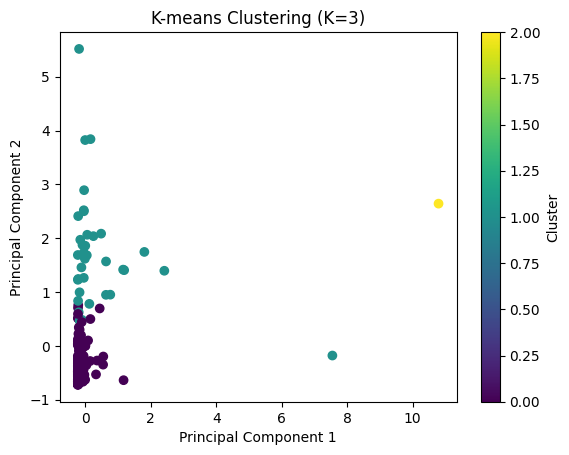

In [103]:
#prepping data for clustering and visualization

#selecting only numeric data for clustering
numeric_columns = ["GDP ($USD)", "GDP per capita ($USD)", "Inflation (index)", "Current account balance ($USD)", "Unemployment rate (%)"]
data_numeric = df_final.drop("Country", axis=1)[numeric_columns]

#scaling data for clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

#k-means clustering
kmeans = KMeans(n_clusters=3, random_state=12)
kmeans.fit(data_scaled)

#predict cluster labels
cluster_labels = kmeans.predict(data_scaled)

plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering (K=3)')
plt.colorbar(label='Cluster')
plt.show()

In [106]:
#find outliers
outlier_indices = (data_scaled[:, 0] > 3) | (data_scaled[:, 1] > 5)
outlier_countries = df_final.index[outlier_indices]

df_final.loc[outlier_countries, 'Country']

35             China
98        Luxembourg
186    United States
Name: Country, dtype: object